the goal is to create a notebook that would allow automatic processing of pairs of SAR images and related model data.

First part collect all variables which setting later could go to configuration file

Second part combines all steps of processing with intermidiate plotting and saving data. Later it should split to different python modules and run by a function from a separate .py with one main method, for example def rub_int_forecast_analysis which would use confic variables

I will try to organize code so rask would be in once cell so it would be convinient to make python files afterwords

At the end I can split this notebook to modules and execution part based on the hashtag at teh top of each cell (maybe automatically with chatGPT)
Would be great if variables from config files or any other varoables used in different modules would be changed to module_name.variable

In [2]:
#Import modules for exwcutions

# If using a new container, a different version of matplotlib should be installed
# To avoid the error while plotting "AttributeError: 'GeoAxes' object has no attribute '_autoscaleXon'"
# Otherwise image should be changed again 
#!pip install --user matplotlib==3.5.2


#from sea_ice_drift.lib import get_spatial_mean, get_uint8_image

### 1. Set parameters the same for all SAR pairs

In [3]:
#module

# ---------------------------------------------------------------------- #
# Name :        config.py
# Purpose :     S1 Image class definitions and functions for preparing pairs of SAR1 and SAR2
# ---------------------------------------------------------------------- #

# ---------------------------------------------------------------------- #
# USER DEFINED PARAMETERS 
#
# ---------------------------------------------------------------------- #

import xarray as xr
import re
from nansat import Nansat, Domain, NSR

# -----------------------------
# Directories and File Paths
# -----------------------------

# Path to directory containing geocoded HH-polarized Sentinel-1 images
path_to_HH_files = '/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HH_HV_160_for_batch_processing/test/HH_160'
#path_to_HH_files = '/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HV_40'

# Path to directory containing geocoded HV-polarized Sentinel-1 images
path_to_HV_files = '/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HH_HV_160_for_batch_processing/test/HV_160'
#path_to_HV_files = '/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HV_40'

# Directory containing the SAFE formatted Sentinel-1 images
safe_folder = '/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/safe_test'

output_folder =  '/home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output'
# -----------------------------
# Regular Expressions
# -----------------------------

# Regular expression for matching geocoded Sentinel-1 product file names
# Such suffixes as Orb, Cal, TC, polarisation band and then resolution are added during geocoding based on steps and parameters
# Geocoding is happening in a separate environment using snappy module
S1_prod_regex = (r'S1[AB]{1}_EW_GRDM_1[A-Z]{3}_(?P<start_timestamp>[0-9]{8}T[0-9]{6})_'
                r'[0-9]{8}T[0-9]{6}_[0-9]{6}_[0-9A-Z]{6}_(?P<product_id>[0-9A-Z]{4})_Orb_Cal_TC_'
                r'(?P<polarisation>H[HV]{1})_(?P<resolution>[0-9]{1,4})')

# Regular expression for matching SAFE formatted Sentinel-1 file names
S1_safe_regex = (r'S1[AB]{1}_EW_GRDM_1[A-Z]{3}_(?P<start_timestamp>[0-9]{8}T[0-9]{6})_'
                r'[0-9]{8}T[0-9]{6}_[0-9]{6}_[0-9A-Z]{6}_(?P<product_id>[0-9A-Z]{4})')


# Compile the regular expression for matching Sentinel file names.
S1_prod_regex = re.compile(S1_prod_regex)  
S1_safe_regex = re.compile(S1_safe_regex) 


# -----------------------------
# Grid Configuration
# -----------------------------

'''!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!! Save them and upload as parameters not depending in url
'''

# Load the data grid based on a model dataset
data_grid = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_surface/2023/09/07/T18Z/barents_sfc_20230907T18Zm23.nc")

# Extract the X, Y, longitude, and latitude coordinates from the dataset
# It will be a base for creating a model domain for fretriving sar drift with the same resolution as Barents2.5 data 
# and for comparison domain where all SAR images (real and forecasted) will be projected to  .
X = data_grid['X']
Y = data_grid['Y']
lon = data_grid['lon']
lat = data_grid['lat']

# Extract the proj4 string defining the dataset's Lambert Conformal projection
proj4 = data_grid.projection_lambert.proj4

# Convert the proj4 string to a Nansat spatial reference object
srs = NSR(proj4)

### 2. Prepare SAR pairs

In [4]:
#module

# ---------------------------------------------------------------------- #
# Name :        s1_preparation.py
# Purpose :     S1 Image class definitions and functions for preparing pairs of SAR1 and SAR2
# ---------------------------------------------------------------------- #

import re
import datetime
import os

''' 
Comments
----------

SAFE files were geocoded separatly usign snappy module usifn following parameters:

sentinel_processor(in_folder, output_folder, polarisation_mode = 'DH', polarisation_bands = 'HH,HV', pixel_spacing = 160, crs = custom_crs_wkt, resampling_method = 'BILINEAR_INTERPOLATION')

Regular expression for output file differs from the original safe files by having a few extra suffixes at the end, for example:
S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV_160.tif

custom_crs_wkt = 'PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6371000,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],
                PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",77.5],PARAMETER["central_meridian",-25],PARAMETER["standard_parallel_1",77.5],
                PARAMETER["standard_parallel_2",77.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],
                AXIS["Northing",NORTH]]'
'''

class S1Image:
    
    ''' 
    Container for Sentinel-1 product. 
    
    It contains information about path to SAFE file and timestamp.
    It also extract 2 filapaths to corresponding geocoded HH and HV tiff files matching them by similar product ID in regex patterns.
    
    This class holds information about the path to a SAFE file.
    It extracts its timestamp, product ID and file paths to the corresponding geocoded
    HH and HV TIFF files by matching them using similar product IDs defined in regex patterns.
    
    
    Attributes
    ----------
    filepath : str
        - Full path to the Sentinel-1 SAFE product file.
    filename : str
        - Name of the Sentinel-1 SAFE product file.
    timestamp : datetime.datetime
        - Acquisition time of the product.
    id : str
        - Sentinel-1 image ID.
    HH_tif_filepath : str
        - Full path to the corresponding HH polarisation TIFF file.
    HV_tif_filepath : str
        - Full path to the corresponding HV polarisation TIFF file.
        
    Class Methods
    -------------
    find_hh_tif_filepath(filename) : str
        - Locates and returns the path of the geocoded HH polarisation TIFF file 
          corresponding to the given SAFE file name.
    find_hv_tif_filepath(filename) : str
        - Locates and returns the path of the geocoded HV polarisation TIFF file 
          corresponding to the given SAFE file name.
          
    '''
   

    @classmethod
    def find_hh_tif_filepath(cls, filename):
        safe_match = S1_safe_regex.match(filename)
        if not safe_match:
            return None
        for tif_file in os.listdir(path_to_HH_files):
            tif_match = S1_prod_regex.match(tif_file)
            if tif_match and safe_match.group('product_id') == tif_match.group('product_id'):
                return os.path.join(path_to_HH_files, tif_file)
        return None

    @classmethod
    def find_hv_tif_filepath(cls, filename):
        safe_match = S1_safe_regex.match(filename)
        if not safe_match:
            return None
        for tif_file in os.listdir(path_to_HV_files):
            tif_match = S1_prod_regex.match(tif_file)
            if tif_match and safe_match.group('product_id') == tif_match.group('product_id'):
                return os.path.join(path_to_HV_files, tif_file)
        return None

    def __init__(self, filepath):
        self.filepath = filepath
        self.filename = os.path.basename(filepath)
        # Attempt to match the filename against the predefined regex pattern.
        match = S1_safe_regex.search(self.filename)
        if not match:
            raise ValueError(f"File {self.filename} does not match the expected pattern.")
        self.timestamp = datetime.datetime.strptime(match.group('start_timestamp'), '%Y%m%dT%H%M%S')
        self.id = match.group('product_id')
        self.HH_tif_filepath = self.find_hh_tif_filepath(self.filename)
        self.HV_tif_filepath = self.find_hv_tif_filepath(self.filename)
        
        
    def __repr__(self):
        return f"S1Image(ID={self.id}, timestamp={self.timestamp.strftime('%Y%m%dT%H%M%S')})"

    
        
# Function to collect and create S1Image objects for all Sentinel files in a directory.
def collect_sentinel_files(directory):
    # Initialize an empty list to store S1Image objects
    sentinel_files = []

    # Loop through each file in the directory
    for filename in os.listdir(directory):
        # Check if the file has a .tif extension
        if filename.endswith('.SAFE'):
            # Create the full path to the file
            full_path = os.path.join(directory, filename)
            
            # Create a S1Image object and add it to the list
            try:
                sentinel_file = S1Image(full_path)
                sentinel_files.append(sentinel_file)
            except ValueError:
                # This will skip files that don't match the expected pattern
                continue

    # Check if the list is empty and raise an exception
    if not sentinel_files:
        raise ValueError("No objects were created as no files matched the criteria.")
        
    # Sort the list of S1Image objects by their timestamp
    sorted_files = sorted(sentinel_files, key=lambda x: x.timestamp)
    
    return sorted_files
    

# Function to get pairs of Sentinel files where the difference in their timestamps is within a given limit.
def get_pairs_within_time_limit(files, hours=60):
    pairs = []
    for i in range(len(files)):
        for j in range(i+1, len(files)):
            if (files[j].timestamp - files[i].timestamp).total_seconds() <= hours * 3600:
                pairs.append((files[i], files[j]))
            else:
                break  # break inner loop since the list is sorted and no other pairs will fit the criteria

    if not pairs:
        print(f"No pairs found with a time difference of {hours} hours or less.")

    return pairs


In [5]:
# Execution

# Collect Sentinel SAFE objects for files in safe directory.
safe_objects = collect_sentinel_files(safe_folder)

# Get pairs of Sentinel SAFE objects where their timestamps are within 50 hours of each other.
sar_pairs = get_pairs_within_time_limit(safe_objects, hours = 50)

# Print details for each pair.
for index, pair in enumerate(sar_pairs, start=1):  # start=1 makes the index start from 1
    print(f'Pair {index}:')
    print(f'SAR1: {pair[0].filename} \ntimestamp: {pair[0].timestamp}\n'
          f'SAR2: {pair[1].filename} \ntimestamp: {pair[1].timestamp}')

Pair 1:
SAR1: S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1.SAFE 
timestamp: 2022-11-20 08:01:55
SAR2: S1A_EW_GRDM_1SDH_20221122T074535_20221122T074639_046004_05816B_9FC9.SAFE 
timestamp: 2022-11-22 07:45:35
Pair 2:
SAR1: S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB.SAFE 
timestamp: 2023-02-12 08:01:51
SAR2: S1A_EW_GRDM_1SDH_20230214T074531_20230214T074635_047229_05AAC8_4014.SAFE 
timestamp: 2023-02-14 07:45:31


### 3. Prepare nansat objects and domains (for each sar pair)

- Set subset calculation grid by clipping the full model grid
- Define model domain for comparing drift
- Define comparison domain to compare SAR images (real and forecasted)

In [11]:
#module

# ---------------------------------------------------------------------- #
# Name :        domains_preparation.py
# Purpose :     Prepare nansat objecys and define domains  
# ---------------------------------------------------------------------- #

import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from osgeo import gdal
from osgeo import osr
from nansat import Nansat, Domain, NSR

from sea_ice_drift import get_n
from sea_ice_drift.lib import get_spatial_mean, get_uint8_image

def prepare_nansat_objects(sar1, sar2, output_folder, polarisation):
    
    """
    Prepare and plot Nansat objects from given SAR images.
    
    The function creates Nansat objects out of a pair of SAR images and saves a side-by-side visualization of the
    processed images. The generated plots and images are saved to a specified output folder, organized by timestamps 
    and polarisation.

    Parameters:
    - sar1: The first SAR image object with attributes 'safe_filepath' and 'timestamp'.
    - sar2: The second SAR image object with attributes 'safe_filepath' and 'timestamp'.
    - polarisation (optional): The polarisation to be used, either 'HV' or 'HH'.

    Returns:
    - n1: Nansat object of the first SAR image after processing.
    - n2: Nansat object of the second SAR image after processing.
    
    """
    
    f1 = sar1.filepath  
    f2 = sar2.filepath

    n1 = get_n(f1, bandName= f'sigma0_{polarisation}', remove_spatial_mean=True) 
    n2 = get_n(f2, bandName= f'sigma0_{polarisation}', remove_spatial_mean=True)
    
    
    # Create directory for saving outputs for each pair of images
    output_dir_name = os.path.join(output_folder, f"{sar1.timestamp.strftime('%Y%m%dT%H%M%S')}_{sar2.timestamp.strftime('%Y%m%dT%H%M%S')}")
    os.makedirs(output_dir_name, exist_ok=True)
    
    # Create directory for saving plots
    plots_dir = os.path.join(output_dir_name, f"{polarisation}_plots")
    os.makedirs(plots_dir, exist_ok=True)
    
    #Plot
    plt.close('all')
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    
    # Set background color to white
    ax[0].set_facecolor('white')
    ax[1].set_facecolor('white')
    fig.set_facecolor('white')
    
    im1 = ax[0].imshow(n1[1], clim=[0, 255])
    ax[0].axis('off')
    #plt.colorbar(im0, ax=ax[0])
    im2 = ax[1].imshow(n2[1], clim=[0, 255])
    ax[1].axis('off')
    #plt.colorbar(im1, ax=ax[1])
    cax = fig.add_axes([0.92, 0.13, 0.02, 0.75])  # Position and size of the colorbar
    cbar = fig.colorbar(im2, cax=cax)
    #plt.colorbar(im3, ax=ax[2])

    ax[0].set_title(f"SAR1 {polarisation} - {sar1.timestamp.strftime('%Y%m%dT%H%M%S')}")
    ax[1].set_title(f"SAR2 {polarisation} - {sar2.timestamp.strftime('%Y%m%dT%H%M%S')}")

    # Save the figure without displaying it
    save_path = os.path.join(plots_dir, f"n1_n2_{polarisation}.png")
    fig.savefig(save_path, dpi=300, bbox_inches='tight')

    # Close it after saving
    plt.close(fig)
  
    return n1, n2, output_dir_name, plots_dir

def prepare_grid(n1, n2, srs, lon, lat, buffer):
    """
    Prepare a subset grid based on teh model grid and based on the bounds of the SAR image, expanded by a buffer.
    
    The function extracts a subset of the grid from the model based on the bounds 
    of the SAR image and adds a buffer to the subset. This buffered subset grid 
    is used for pattern matching to ensure that the drift output aligns seamlessly 
    with the model data.

    Parameters:
    - srs : Desired spatial reference system.
    - lon (xarray.DataArray): Longitudes from the model grid.
    - lat (xarray.DataArray): Latitudes from the model grid.
    - buffer (int): Number of pixels to expand the subset by.

    Returns:
    - X_subset (xarray.DataArray): Subset of X-coordinates based on the SAR image bounds (expanded by buffer).
    - Y_subset (xarray.DataArray): Subset of Y-coordinates based on the SAR image bounds (expanded by buffer).
    - lon_subset (xarray.DataArray): Subset of longitudes based on the SAR image bounds (expanded by buffer).
    - lat_subset (xarray.DataArray): Subset of latitudes based on the SAR image bounds (expanded by buffer).
    - lon1pm (array-like): Longitudes prepared for pattern matching.
    - lat1pm (array-like): Latitudes prepared for pattern matching.
    """
    # get lon/lat coordinates of the border of images
    lon1b, lat1b = n1.get_border()
    lon2b, lat2b = n2.get_border()

    #Get bound in rows and columns correspoding to the image borders set above
    r,c = np.where((lon.data > min(lon1b))*(lon.data <  max(lon1b))*(lat.data >  min(lat1b))*(lat.data < max(lat1b)))
    
    # Add buffer in pixels to make a subset biger to take into account drift
    min_row, max_row, min_col, max_col = min(r) - buffer, max(r) + buffer, min(c) - buffer, max(c) + buffer
    
    # Extract the subset grif out of the model grid based on the image bounds
    #That grid and srs will be used for pattern matching ensuring the drift output aligns easily with the model data.
    X_subset = X[min_col:max_col+1]
    Y_subset = Y[min_row:max_row+1]
    lon_subset = lon[min_row:max_row+1, min_col:max_col+1]
    lat_subset = lat[min_row:max_row+1, min_col:max_col+1]


    # Prepare coordinates for patern matching input
    lon1pm = lon_subset.data
    lat1pm = lat_subset.data

    # Set up coordinates in meters for visualizing the pattern matching results.
    x1pm, y1pm = np.meshgrid(X_subset, Y_subset)
    return X_subset, Y_subset, x1pm, y1pm, lon_subset, lat_subset, lon1pm, lat1pm

def plot_borders(mod_dom, n1, n2, output_dir_name):
    """
    Plot borders of model subset domain and two Sentinel images.

    Parameters:
    - mod_dom: Model subset domain object with a get_border() method
    - n1: First Sentinel image object with a get_border() method
    - n2: Second Sentinel image object with a get_border() method
    - output_dir_name: Directory path for saving the plotted figure

    Returns:
    - save_path: Full path to the saved figure
    """
    plt.close('all')
    # Set up the plot
    fig, axs = plt.subplots(1, 1, figsize=(8, 8))
    axs.plot(*mod_dom.get_border(), '.-', label='Model subset domain')
    axs.plot(*n1.get_border(), '.-', label='First S1 image')
    axs.plot(*n2.get_border(), '.-',  label='First S2 image')
    plt.legend()

    # Define save path
    general_save_path = os.path.join(output_dir_name, "General_plots")
    os.makedirs(general_save_path, exist_ok=True)
    save_path = os.path.join(general_save_path, "images_vs_domain_borders.png")
    # Save the figure
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    # Close the figure
    plt.close(fig)

    return save_path


In [12]:
#Prepare nansat objects for HV polarisation
n1_hv, n2_hv, output_dir_name, plots_dir_hv =  prepare_nansat_objects(sar_pairs[1][0], sar_pairs[1][1], output_folder, polarisation='HV')

#Prepare nansat objects for HH polarisation
n1_hh, n2_hh, output_dir_name, plots_dir_hh =  prepare_nansat_objects(sar_pairs[1][0], sar_pairs[1][1], output_folder, polarisation='HH')


# Prepare subset model grid for domains and pattern matching
X_subset, Y_subset, x1pm, y1pm, lon_subset, lat_subset, lon1pm, lat1pm = prepare_grid(n1_hv, n2_hv, srs, lon, lat, buffer=0)

# Set a model domain 
mod_dom = Domain(srs, f'-te {min(X_subset.data)} {min(Y_subset.data)} {max(X_subset.data)} {max(Y_subset.data)} -tr 2500 2500')

# Set a comparison domain 
dst_dom = Domain(srs, f'-te {min(X_subset.data)} {min(Y_subset.data)} {max(X_subset.data)} {max(Y_subset.data)} -tr 100 100')

plot_borders(mod_dom, n1_hv, n2_hv, output_dir_name) # borders for hh and hv are the same


VMIN:  -3.9498636960983275
VMAX:  5.663959283828735
VMIN:  -3.5571017265319824
VMAX:  5.484246134757996
VMIN:  -3.774366235733032
VMAX:  5.102492332458496
VMIN:  -3.0308663845062256
VMAX:  4.180728316307068


'/home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/20230212T080151_20230214T074531/General_plots/images_vs_domain_borders.png'

### 4. Retrieve reference drift
- Run feature tracking and pattern matching for HV
- Run feature tracking and pattern matching for HV
- Get combined drift and all parameters

In [31]:
#after change pair number from 1 to i and get it into loop?
# sar1 and sar2 are the first par from pairlist; HV_pairs[1][0] and  HV_pairs[1][1] and which would be substitute for sar_pairs[1][0], sar_pairs[1][1] after switching only to safe files

#module

# ---------------------------------------------------------------------- #
# Name :        SAR1_SAR2_drift_retrivial.py
# Purpose :     Retrieve reference drift for  further comparison with the model data and reference forecast.  
# ---------------------------------------------------------------------- #

import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from osgeo import gdal
from osgeo import osr
from nansat import Nansat, Domain, NSR

from sea_ice_drift.lib import get_spatial_mean, get_uint8_image

from sea_ice_drift.ftlib import feature_tracking
#from sea_ice_drift.pmlib import pattern_matching

import sys
sys.path.append(r'./nersc_drift_algorithm/sea_ice_drift')
from pmlib_with_ssim import pattern_matching

%matplotlib inline

def run_feature_tracking(n1, n2, plots_dir):  
    
    """
    Execute feature tracking between two SAR images and visualize the results.

    This function performs feature tracking between two Nansat objects representing SAR images. 
    It identifies and matches keypoints (features) between the images, then visualizes:
    1. The matched keypoints in geographic coordinates.
    2. The ice drift vectors superimposed on the first SAR image.

    Parameters:
    - n1: The first Nansat object representing a SAR image 1.
    - n2: The second Nansat object representing a SAR image 2.
    - plots_dir: Directory path where the visualizations will be saved.

    Returns:
    - c1, r1: Column and row coordinates of matched keypoints in the first image.
    - c2, r2: Column and row coordinates of matched keypoints in the second image.
    - lon1b, lat1b: Longitude and latitude coordinates of the border of the first image.

    """
        
    # get start/end coordinates in the image coordinate system (colums/rows)  
    c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=50000, ratio_test=0.6, max_drift=100000, verbose=True)

    # Plot identified and matched keypoints in geographic coordinates

    # convert row/column coordinates of matched features to lon/lat
    lon1ft, lat1ft = n1.transform_points(c1, r1)
    lon2ft, lat2ft = n2.transform_points(c2, r2)

    # get lon/lat coordinates of the border of images
    lon1b, lat1b = n1.get_border()
    lon2b, lat2b = n2.get_border()


    # get hi-res landmask
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor=cfeature.COLORS['land'])

    fig, ax = plt.subplots(1,2, figsize=(10,10))
    ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70))
    ax.add_feature(land_50m, zorder=0, edgecolor='black')
    ax.plot(lon1ft, lat1ft, '.', label='keypoints_1', transform=ccrs.PlateCarree())
    ax.plot(lon2ft, lat2ft, '.', label='keypoints_2', transform=ccrs.PlateCarree())
    ax.plot(lon1b, lat1b, '.-', label='border_1', transform=ccrs.PlateCarree())
    ax.plot(lon2b, lat2b, '.-', label='border_2', transform=ccrs.PlateCarree())
    ax.legend()

    # Save the figure without displaying it
    save_path = os.path.join(plots_dir, f"ft_matching_points.png")
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)


    # Plot ice drift on top of image_1

    # end points in image_1 coordinate system
    n1c2, n1r2 = n1.transform_points(lon2ft, lat2ft, DstToSrc=1)

    # ice drift components in image_1 coordinate system
    dr = n1r2 - r1
    dc = n1c2 - c1

    # border of image_2 in image_1 coordinate system
    n1lon2b, n1lat2b = n1.transform_points(lon2b, lat2b, DstToSrc=1)

    # plot of ice drift.
    fig = plt.figure(figsize=(10,10))
    plt.imshow(n1[1], cmap='gray')
    plt.quiver(c1, r1, dc, dr, color='r', angles='xy', scale_units='xy', scale=0.5)
    plt.plot(n1lon2b, n1lat2b, 'k.-')

    # Save the figure without displaying it
    save_path = os.path.join(plots_dir, f"ft_drift_vectors.png")
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    return c1, r1, c2, r2



def run_pattern_matching(plots_dir, lon1pm, lat1pm, n1, c1, r1, n2, c2, r2, srs, **kwargs):
    
    upm, vpm, apm, rpm, hpm, ssim, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                          srs=srs.ExportToProj4(), **kwargs)


    # Plot main parameters
    
    plt.close('all')
    fig, ax = plt.subplots(2, 3, figsize=(20, 10))
    
    # Update titles list with the new plot title
    titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian', 'SSIM']
    # Flatten the ax array for easy indexing
    ax = ax.flatten()

    interval = 100000
    # Update the loop to include the new ma-trix and title
    for i, a in enumerate([upm, vpm, apm, rpm, hpm, ssim]):
        ax[i].set_title(titles[i])
        ax[i].set_facecolor('white')
        im = ax[i].imshow(a, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower')
        plt.colorbar(im, ax=ax[i])
        ax[i].set_xlim([x1pm.min()-10000, x1pm.max()-210000])
        ax[i].set_ylim([y1pm.min()+110000, y1pm.max()-160000])
        
         # Set x-ticks with the desired interval
        ticks = np.arange(x1pm.min(), x1pm.max(), interval)
        ax[i].set_xticks(ticks)
    
    plt.tight_layout()
    fig.set_facecolor('white')
    #plt.show()
    # Save the figure without displaying it
    save_path = os.path.join(plots_dir, f"Pattern_matching_output_parameters.png")
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    
    return upm, vpm, apm, rpm, hpm, ssim, lon2pm, lat2pm 

import numpy as np
import matplotlib.pyplot as plt
import os

def combine_hh_hv(output_dir_name, upm_hh, vpm_hh, apm_hh, rpm_hh, hpm_hh, ssim_hh, lon2pm_hh, lat2pm_hh,
                  upm_hv, vpm_hv, apm_hv, rpm_hv, hpm_hv, ssim_hv, lon2pm_hv, lat2pm_hv):
    """
    This function combines the hv data with hh data where quality of hh data are higher
    (e.g. hessian hh > hessian hv),
    and then creates two plots to visualize the combined data.
    
    Parameters:
    - output_dir_name: Directory to save the generated plots
    - upm_hh, vpm_hh, apm_hh, ... : Data arrays for 'hh' output
    - upm_hv, vpm_hv, apm_hv, ... : Data arrays for 'hv' output
    
    Returns:
    - upm, vpm, apm, rpm, hpm, ssim, lon2pm, lat2pm : Combined data arrays
    """
    
    # Create a mask where hpm_hh is greater than hpm
    mask = hpm_hh > hpm_hv
    
    # Create new arrays as copies of the original arrays
    upm = upm_hv.copy()
    vpm = vpm_hv.copy()
    apm = apm_hv.copy()
    rpm = rpm_hv.copy()
    hpm = hpm_hv.copy()
    ssim = ssim_hv.copy()
    lon2pm = lon2pm_hv.copy()
    lat2pm = lat2pm_hv.copy()

    # Update the combined arrays using the mask
    upm[mask] = upm_hh[mask]
    vpm[mask] = vpm_hh[mask]
    apm[mask] = apm_hh[mask]
    rpm[mask] = rpm_hh[mask]
    hpm[mask] = hpm_hh[mask]
    ssim[mask] = ssim_hh[mask]
    lon2pm[mask] = lon2pm_hh[mask] 
    lat2pm[mask] = lat2pm_hh[mask]

    # Plotting1
    plt.close('all')
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    ax.hist(hpm_hh.flatten(), bins=50, alpha=0.5, label='Hessian HH')
    ax.hist(hpm_hv.flatten(), bins=50, alpha=0.5, label='Hessian HV')
    ax.hist(hpm.flatten(), bins=50, alpha=0.5, label='Hessian hh + HV')

    ax.legend(loc='upper right')
    ax.set_title('Histogram of hessian HV, HH, and combined HH + HV')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(True)
    
    # Set background color to white
    ax.set_facecolor('white')
    fig.set_facecolor('white')

    # Define save path
    general_save_path = os.path.join(output_dir_name, "General_plots")
    os.makedirs(general_save_path, exist_ok=True)
    save_path = os.path.join(general_save_path, "hessian_HH_vs_HV_histogram.png")
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

    # Plotting2
    plt.close('all')
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Scatter plot
    ax.scatter(hpm_hv.flatten(), hpm_hh.flatten(), alpha=0.5)

    # Add y=x line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, label='y=x line')

    ax.set_title('Scatter plot of hessian HV vs hessian HH')
    ax.set_xlabel('Hessian HV')
    ax.set_ylabel('Hessian HH')
    ax.grid(True)
    ax.legend()
    
    # Set background color to white
    ax.set_facecolor('white')
    fig.set_facecolor('white')

    # Define save path
    save_path = os.path.join(general_save_path, "hessian_HH_vs_HV_graph.png")
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    return upm, vpm, apm, rpm, hpm, ssim, lon2pm, lat2pm


#### 4.1 HV processing

In [20]:
# Run feature tracking and plot results 
c1_hv, r1_hv, c2_hv, r2_hv = run_feature_tracking(n1_hv, n2_hv, plots_dir_hv)

#Run pattern matching and plot results
upm_hv, vpm_hv, apm_hv, rpm_hv, hpm_hv, ssim_hv, lon2pm_hv, lat2pm_hv = run_pattern_matching(plots_dir_hv, lon1pm, lat1pm, n1_hv, c1_hv, r1_hv, n2_hv, c2_hv, r2_hv, srs, 
                                                           min_border=20,
                                                           max_border=20,
                                                           angles=[ -3, 0, 3])
                                                           #angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])

Key points found: 50000
Key points found: 50000
Domain filter: 50000 -> 37701
Domain filter: 50000 -> 48850
Keypoints matched 3.975787401199341
Ratio test 0.600000 found 1552 keypoints
MaxDrift filter: 1552 -> 1552
LSTSQ filter: 1552 -> 1523


/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


95% 02210.4 00313.3 02970.0 00379.0 +00.0 0.58 15.16 0.52
 Pattern matching - OK! ( 12 sec)


#### 4.2 HH Processing

In [ ]:
# Run feature tracking and plot results 
c1_hh, r1_hh, c2_hh, r2_hh = run_feature_tracking(n1_hh, n2_hh, plots_dir_hh)

#Run pattern matching and plot results
upm_hh, vpm_hh, apm_hh, rpm_hh, hpm_hh, ssim_hh, lon2pm_hh, lat2pm_hh = run_pattern_matching(plots_dir_hh, lon1pm, lat1pm, n1_hh, c1_hh, r1_hh, n2_hh, c2_hh, r2_hh,srs, 
                                                           min_border=200,
                                                           max_border=200,
                                                           angles=[ -3, 0, 3])
                                                           #angles=[-100, -90, -80, -70, -60, -50, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 50 , 60, 70, 80, 90, 100])

Key points found: 50000
Key points found: 50000
Domain filter: 50000 -> 43258
Domain filter: 50000 -> 48486
Keypoints matched 4.503424644470215
Ratio test 0.600000 found 489 keypoints
MaxDrift filter: 489 -> 489
LSTSQ filter: 489 -> 481
85% 01089.1 00704.4 01895.0 00834.0 +00.0 0.26 7.75 0.19n
 Pattern matching - OK! ( 81 sec)


#### 4.3 Combining

In [32]:
# COmbining hh and jv results based on hessian threshold
upm, vpm, apm, rpm, hpm, ssim, lon2pm, lat2pm = combine_hh_hv(output_dir_name, upm_hh, vpm_hh, apm_hh, rpm_hh, hpm_hh, ssim_hh, lon2pm_hh, lat2pm_hh,
                              upm_hv, vpm_hv, apm_hv, rpm_hv, hpm_hv, ssim_hv, lon2pm_hv, lat2pm_hv)

### 5. Model data retriev

### 6. Drift comparison

### 7. Forecast with reference data

### 8. Forecast with model data

### 9. Forecast comparison

### 10. Deforamtion calculation

In [66]:

# Get n for vizualizaton and reprojecting
#n1.reproject(dst_dom) #n1.export
#n1b1 = n1[1]
#n1.undo()
n2.reproject(dst_dom) #n1.export
n2b1 = n2[1]
n2.undo()

Number of True values without filtering : 8915


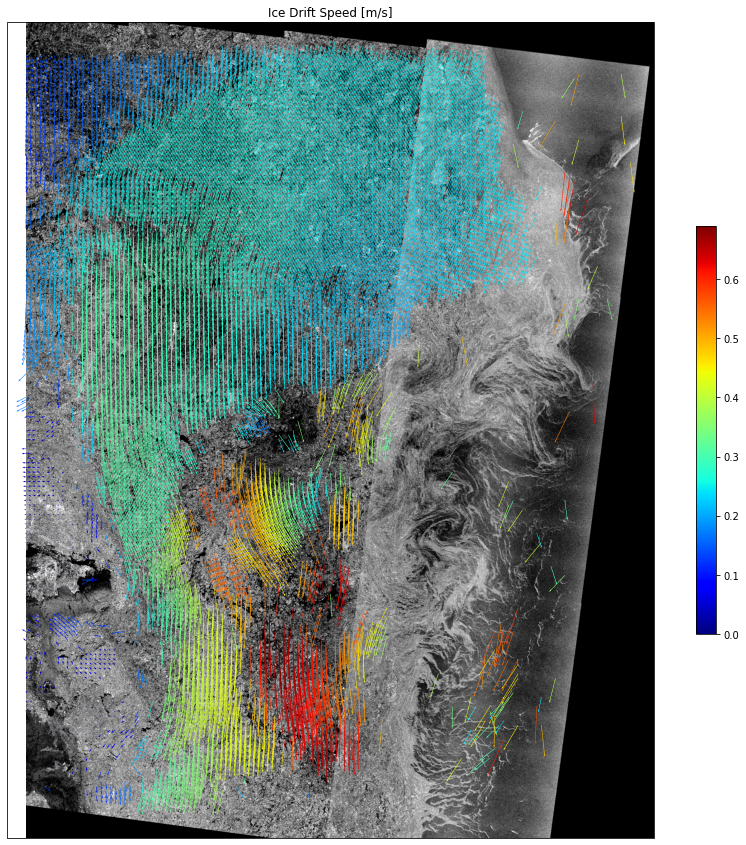

In [106]:
dayssec = 60*60*24

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = upm / delta_t
v = vpm / delta_t
speed = np.sqrt((v**2+u**2)) 

# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with three subplots side by side
plt.figure(figsize=(15,15))
ax =plt.axes(projection=crs) 

# Figure 1

# filter vectors with hessian value
gpi = (hpm > 8) 
num_true_values = np.sum(gpi.data)
print(f"Number of True values without filtering : {num_true_values}")

# Plot the image on the first subplot
#

ax.imshow(n1b1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
filtered_hpm = np.where(hpm > 7, hpm, np.nan)
#h_img = ax.imshow(filtered_hpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='jet', alpha=0.4, vmin=0, vmax=25)
#quiv1 = ax.quiver(x1pm[gpi][::4], y1pm[gpi][::4], u[gpi][::4], v[gpi][::4], speed[gpi][::4], scale=5, cmap='jet', width=0.0035)
quiv1 = ax.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1], speed[gpi][::1], scale=10, cmap='jet', width=0.0008)
ax.set_title('Ice Drift Speed [m/s]')
#ax.add_feature(land_50m, edgecolor='black')
ax.set_xlim([x1pm.min()-10000, x1pm.max()-210000])
ax.set_ylim([y1pm.min()+110000, y1pm.max()-160000])
plt.colorbar(quiv1, ax=ax, orientation='vertical', shrink=0.5)


plt.show()


In [ ]:
  # Create directory for saving plots
    timestamp1 = os.path.basename(f1).split('_')[4]
    timestamp2 = os.path.basename(f2).split('_')[4]
    dir_name = f"{timestamp1}_{timestamp2}_{polarisation.split('_')[-1]}"
    os.makedirs(dir_name, exist_ok=True)

    # Save figures
    plt.savefig(os.path.join(dir_name, 'figure_name.png'), dpi=300, bbox_inches='tight')

#### Draft cells

In [52]:
# HV processing
# Download arrays
f1 = gdal.Open(HV_pairs[1][0].filepath)
f2 = gdal.Open(HV_pairs[1][1].filepath)

#Set domains based on the data
n1_domen = Nansat(HV_pairs[1][0].filepath)
n2_domen = Nansat(HV_pairs[1][1].filepath)

In [53]:
#Load the data from the files into numpy arrays for further processing.
a1 = f1.ReadAsArray() 
a2 = f2.ReadAsArray()

#Pre-process images to ensure consistent visualization and handle blank spots issue after pattern patching.
a1 = get_uint8_image(a1, None, None, 1, 99)
a2 = get_uint8_image(a2, None, None, 1, 99)

VMIN:  0.0
VMAX:  0.021238385755568752
VMIN:  0.0
VMAX:  0.01598892150446774


In [55]:
# Create three Nansat objects with original tiff domains imported from gdal object.
n1 = Nansat.from_domain(n1_domen, a1)
n2 = Nansat.from_domain(n2_domen, a2)

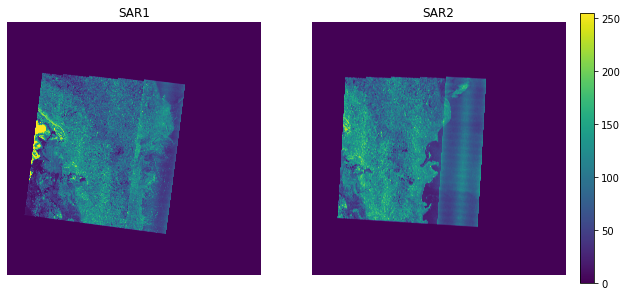

In [54]:
#Plot
fig, ax = plt.subplots(1,2, figsize=(10,5))
im1 = ax[0].imshow(n1[1], clim=[0, 255])
ax[0].axis('off')
#plt.colorbar(im0, ax=ax[0])
im2 = ax[1].imshow(n2[1], clim=[0, 255])
ax[1].axis('off')
#plt.colorbar(im1, ax=ax[1])
cax = fig.add_axes([0.92, 0.13, 0.02, 0.75])  # Position and size of the colorbar
cbar = fig.colorbar(im2, cax=cax)
#plt.colorbar(im3, ax=ax[2])

ax[0].set_title("SAR1")
ax[1].set_title("SAR2")

#ax[0].set_xlim([0.28e6, 0.62e6]) 
#ax[0].set_ylim([0.16e6, 0.6e6])

#ax[1].set_xlim([0.28e6, 0.62e6]) 
#ax[1].set_ylim([0.16e6, 0.6e6])
plt.show()




In [56]:
# Close the dataset
f2 = None
f3 = None

In [57]:
# Run Feature Tracking
# get start/end coordinates in the image coordinate system (colums/rows)  
c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=50000, ratio_test=0.6, max_drift=100000, verbose=True)

Key points found: 50000
Key points found: 50000
Domain filter: 50000 -> 49994
Domain filter: 50000 -> 50000
Keypoints matched 5.154311895370483
Ratio test 0.600000 found 952 keypoints
MaxDrift filter: 952 -> 949
LSTSQ filter: 949 -> 949


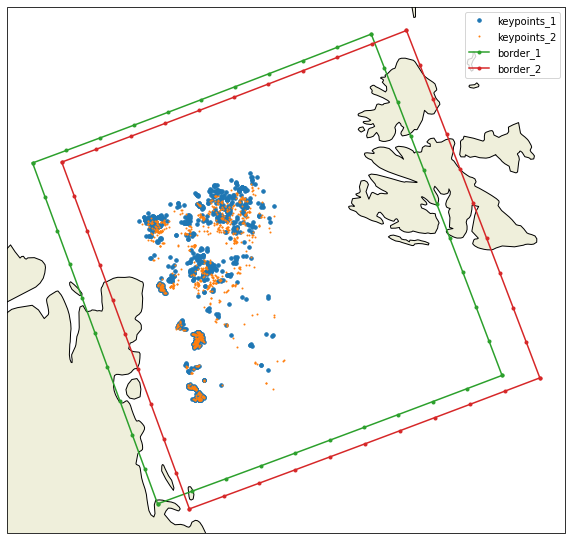

In [58]:
# Plot identified and matched keypoints in geographic coordinates

# convert row/column coordinates of matched features to lon/lat
lon1ft, lat1ft = n1.transform_points(c1, r1)
lon2ft, lat2ft = n2.transform_points(c2, r2)

# get lon/lat coordinates of the border of images
lon1b, lat1b = n1.get_border()
lon2b, lat2b = n2.get_border()


# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70))
ax.add_feature(land_50m, zorder=0, edgecolor='black')
ax.plot(lon1ft, lat1ft, '.', label='keypoints_1', transform=ccrs.PlateCarree(), markersize=7)
ax.plot(lon2ft, lat2ft, '.', label='keypoints_2', transform=ccrs.PlateCarree(), markersize=2)
ax.plot(lon1b, lat1b, '.-', label='border_1', transform=ccrs.PlateCarree())
ax.plot(lon2b, lat2b, '.-', label='border_2', transform=ccrs.PlateCarree())
ax.legend()
plt.show()

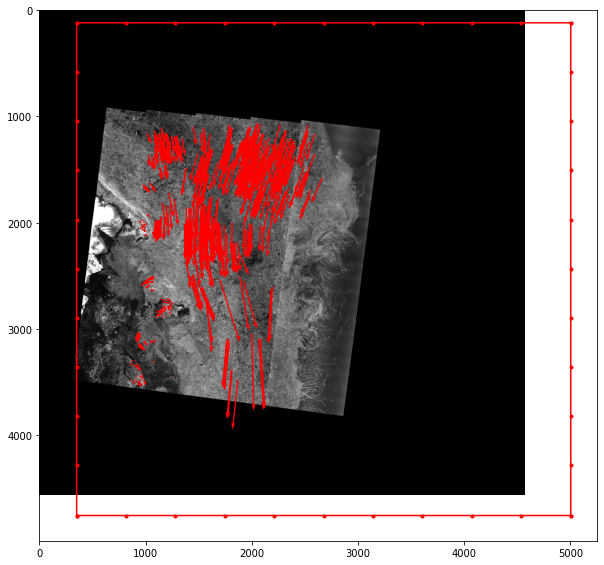

In [59]:

# Plot ice drift on top of image_1

# end points in image_1 coordinate system
n1c2, n1r2 = n1.transform_points(lon2ft, lat2ft, DstToSrc=1)

# ice drift components in image_1 coordinate system
dr = n1r2 - r1
dc = n1c2 - c1

# border of image_2 in image_1 coordinate system
n1lon2b, n1lat2b = n1.transform_points(lon2b, lat2b, DstToSrc=1)

# plot of ice drift. Arrows are 5 times longer than actual drift
plt.figure(figsize=(10,10))
plt.imshow(n1[1], cmap='gray')
plt.quiver(c1, r1, dc, dr, color='r', angles='xy', scale_units='xy', scale=0.5)
plt.plot(n1lon2b, n1lat2b, 'r.-')

plt.show()
#filename = '/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/Nansen_output/2500m/FT_example_HH#_1image.png'
#plt.savefig(filename, dpi=300, bbox_inches='tight')

In [60]:
# get lon/lat coordinates of the border of images
# when using .tiff instead of .safe bounds include nodata area around that makes the extent bigger than needed
lon1b, lat1b = n1.get_border()
lon2b, lat2b = n2.get_border()

In [61]:
# Convert the proj4 string to a Nansat spatial reference object
srs = NSR(proj4)

#Get bound in rows and columns correspoding to the image borders
r,c = np.where((lon.data > min(lon1b))*(lon.data <  max(lon1b))*(lat.data >  min(lat1b))*(lat.data < max(lat1b)))
               
min_row, max_row, min_col, max_col = min(r), max(r), min(c), max(c)

In [62]:
from osgeo import osr

srs = osr.SpatialReference()
srs.ImportFromProj4(proj4)
wkt = srs.ExportToWkt()
wkt

'PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6371000,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",77.5],PARAMETER["central_meridian",-25],PARAMETER["standard_parallel_1",77.5],PARAMETER["standard_parallel_2",77.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

In [63]:
# Extract the subset grid out of the model grid based on the image bounds
#That grid and srs will be used for pattern matching ensuring the drift output aligns easily with the model data.
X_subset = X[min_col:max_col+1]
Y_subset = Y[min_row:max_row+1]
lon_subset = lon[min_row:max_row+1, min_col:max_col+1]
lat_subset = lat[min_row:max_row+1, min_col:max_col+1]


# Prepare coordinates for patern matching input
lon1pm = lon_subset.data
lat1pm = lat_subset.data

# Set up coordinates in meters for visualizing the pattern matching results.
x1pm, y1pm = np.meshgrid(X_subset, Y_subset)

In [64]:
## Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Stereographic projection
upm, vpm, apm, rpm, hpm,best_ssim, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                          srs=srs.ExportToProj4(),
                                                           min_border=200,
                                                           max_border=200,
                                                           angles=[-15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15])

/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.me

/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


100% 04226.8 00056.3 03572.0 00091.0 -15.0 1.00 0nan
 Pattern matching - OK! (548 sec)


In [136]:
upm

NameError: name 'upm' is not defined

In [70]:
## Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Stereographic projection
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching1(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2, img_size = 35,
                                                          srs=srs.ExportToProj4(),
                                                           min_border=50,
                                                           max_border=50,
                                                           angles=[-12, -9,-6, -3, 0, 3, 6, 9, 12])

/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide


/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide


80% 02070.8 00931.3 01639.0 00917.0 -12.0 1.00 0nann1% 03507.8 03556.3 03029.0 03607.0 -12.0 1.00 0nan01% 03648.8 04447.3 03166.0 04492.0 -12.0 1.00 0nan29% 04492.8 03197.3 03981.0 03338.0 -12.0 1.00 0nan35% 03164.8 02963.3 02698.0 02998.0 -12.0 1.00 0nan50% 04164.8 02275.3 03664.0 02408.0 -12.0 1.00 0nan40% 01539.8 02713.3 01251.0 02750.0 -03.0 0.24 8.7687% 02085.8 00603.3 01653.0 00597.0 -12.0 1.00 0nan92% 02617.8 00384.3 02167.0 00427.0 -12.0 1.00 0nan77% 04445.8 01056.3 03934.0 01238.0 -12.0 1.00 0nan92% 04179.8 00384.3 03677.0 00558.0 -12.0 1.00 0nan94% 01429.8 00322.3 01019.0 00267.0 -12.0 1.00 0nan78% 01695.8 00994.3 01338.0 01027.0 +00.0 0.64 6.49
 Pattern matching - OK! ( 81 sec)


In [22]:
## Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Stereographic projection
upm, vpm, apm, rpm, hpm, best_ssim, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                          srs=srs.ExportToProj4(),
                                                           min_border=100,
                                                           max_border=100,
                                                           angles=[-12, -9,-6, -3, 0, 3, 6, 9, 12])

/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
/opt/conda/lib/python

/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


100% 16468.1 00037.2 14519.0 00723.0 -12.0 1.00 0nan90% 13156.1 01912.2 11335.0 02320.0 -12.0 1.00 0nan79% 13156.1 03787.2 11347.0 04190.0 -12.0 1.00 0nan
 Pattern matching - OK! (182 sec)


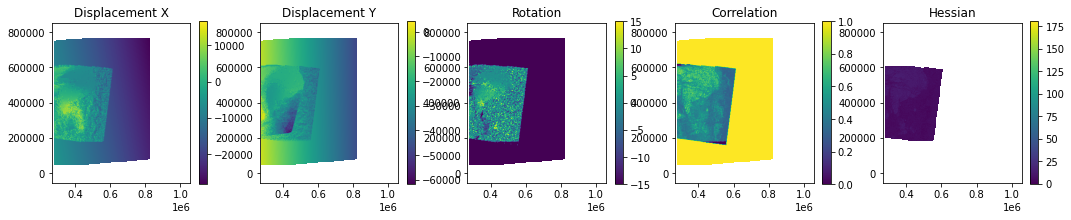

In [41]:
# plot retrieved matrices
titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian']
fig, ax = plt.subplots(1,5, figsize=(18,3))
for i, a in enumerate([upm, vpm, apm, rpm, hpm]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower')
    plt.colorbar(im, ax=ax[i])
    ax[i].set_xlim([x1pm.min()-10000, x1pm.max()-210000])
    ax[i].set_ylim([y1pm.min()+110000, y1pm.max()-160000])

plt.show()

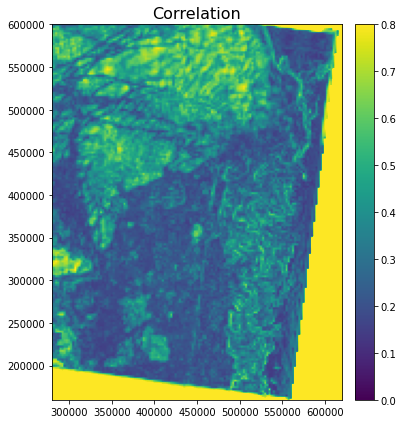

In [65]:
# plot retrieved matrices
fig, ax = plt.subplots(1,1, figsize=(18,6))

# Set title and labels
ax.set_title('Correlation', fontsize=16)
#ax.set_xlabel('Longitude (in projection units)', fontsize=14)
#ax.set_ylabel('Latitude (in projection units)', fontsize=14)

# Display the data with a colormap that provides better contrast and understanding
#im = ax.imshow(best_ssim, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 1,  cmap='viridis')
# Display the data with a colormap that provides better contrast and understanding
im = ax.imshow(rpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 0.8, cmap='viridis')

# Add a colorbar with a label
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.01)
#cbar.set_label('SSIM Value', fontsize=14)


# Set fewer x and y ticks
ax.tick_params(axis='both')#, labelsize=12)
ax.set_xlim([0.28e6, 0.62e6]) 
ax.set_ylim([0.16e6, 0.6e6])


plt.tight_layout()

# Save plot
#plt.savefig("/home/jovyan/experiment_data/2022-2023_48h_experiment/figures/ssim_alg_sar2.png", dpi=300, bbox_inches='tight')


plt.show()


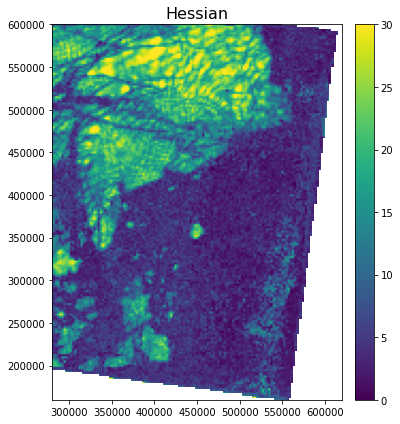

In [66]:
# plot retrieved matrices
fig, ax = plt.subplots(1,1, figsize=(18,6))

# Set title and labels
ax.set_title('Hessian', fontsize=16)
#ax.set_xlabel('Longitude (in projection units)', fontsize=14)
#ax.set_ylabel('Latitude (in projection units)', fontsize=14)

# Display the data with a colormap that provides better contrast and understanding
#im = ax.imshow(best_ssim, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 1,  cmap='viridis')
# Display the data with a colormap that provides better contrast and understanding
im = ax.imshow(hpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 30, cmap='viridis')

# Add a colorbar with a label
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.01)
#cbar.set_label('SSIM Value', fontsize=14)


# Set fewer x and y ticks
ax.tick_params(axis='both')#, labelsize=12)
ax.set_xlim([0.28e6, 0.62e6]) 
ax.set_ylim([0.16e6, 0.6e6])


plt.tight_layout()

# Save plot
#plt.savefig("/home/jovyan/experiment_data/2022-2023_48h_experiment/figures/ssim_alg_sar2.png", dpi=300, bbox_inches='tight')


plt.show()


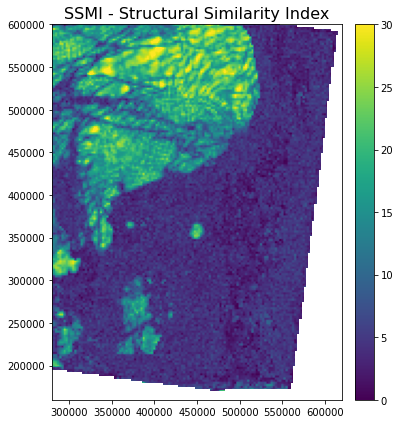

In [74]:
# plot retrieved matrices
fig, ax = plt.subplots(1,1, figsize=(18,6))

# Set title and labels
ax.set_title('SSMI - Structural Similarity Index', fontsize=16)
#ax.set_xlabel('Longitude (in projection units)', fontsize=14)
#ax.set_ylabel('Latitude (in projection units)', fontsize=14)

# Display the data with a colormap that provides better contrast and understanding
#im = ax.imshow(best_ssim, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 1,  cmap='viridis')
# Display the data with a colormap that provides better contrast and understanding
im = ax.imshow(hpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 30, cmap='viridis')

# Add a colorbar with a label
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.01)
#cbar.set_label('SSIM Value', fontsize=14)


# Set fewer x and y ticks
ax.tick_params(axis='both')#, labelsize=12)
ax.set_xlim([0.28e6, 0.62e6]) 
ax.set_ylim([0.16e6, 0.6e6])


plt.tight_layout()

# Save plot
#plt.savefig("/home/jovyan/experiment_data/2022-2023_48h_experiment/figures/ssim_alg_sar2.png", dpi=300, bbox_inches='tight')


plt.show()


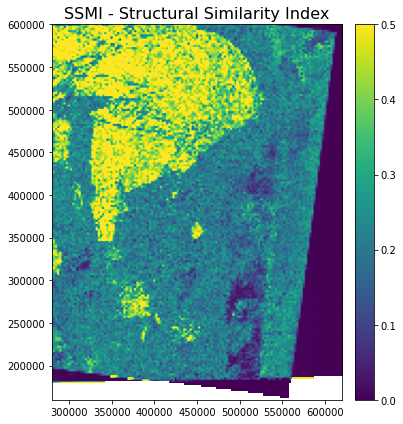

In [74]:
# plot retrieved matrices
fig, ax = plt.subplots(1,1, figsize=(18,6))

# Set title and labels
ax.set_title('SSMI - Structural Similarity Index', fontsize=16)
#ax.set_xlabel('Longitude (in projection units)', fontsize=14)
#ax.set_ylabel('Latitude (in projection units)', fontsize=14)

# Display the data with a colormap that provides better contrast and understanding
im = ax.imshow(best_ssim, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 0.5,  cmap='viridis')
# Display the data with a colormap that provides better contrast and understanding
#im = ax.imshow(hpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 30, cmap='viridis')

# Add a colorbar with a label
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.01)
#cbar.set_label('SSIM Value', fontsize=14)


# Set fewer x and y ticks
ax.tick_params(axis='both')#, labelsize=12)
ax.set_xlim([0.28e6, 0.62e6]) 
ax.set_ylim([0.16e6, 0.6e6])


plt.tight_layout()

# Save plot
#plt.savefig("/home/jovyan/experiment_data/2022-2023_48h_experiment/figures/ssim_alg_sar2.png", dpi=300, bbox_inches='tight')


plt.show()


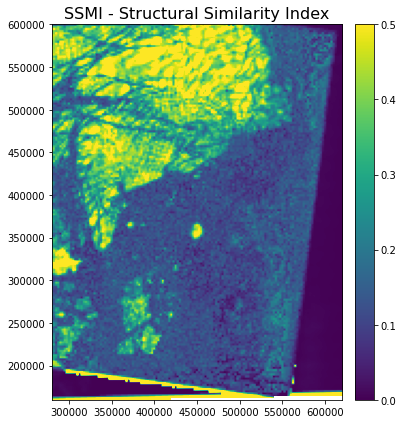

In [258]:
# plot retrieved matrices
fig, ax = plt.subplots(1,1, figsize=(18,6))

# Set title and labels
ax.set_title('SSMI - Structural Similarity Index', fontsize=16)
#ax.set_xlabel('Longitude (in projection units)', fontsize=14)
#ax.set_ylabel('Latitude (in projection units)', fontsize=14)

# Display the data with a colormap that provides better contrast and understanding
im = ax.imshow(best_ssim, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 0.5, cmap='viridis')

# Add a colorbar with a label
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.01)
#cbar.set_label('SSIM Value', fontsize=14)


# Set fewer x and y ticks
ax.tick_params(axis='both')#, labelsize=12)
ax.set_xlim([0.28e6, 0.62e6]) 
ax.set_ylim([0.16e6, 0.6e6])


plt.tight_layout()

# Save plot
#plt.savefig("/home/jovyan/experiment_data/2022-2023_48h_experiment/figures/ssim_alg_sar2.png", dpi=300, bbox_inches='tight')


plt.show()


In [260]:
## Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Stereographic projection
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                          srs=srs.ExportToProj4(),
                                                           min_border=100,
                                                           max_border=100,
                                                           angles=[-12, -9,-6, -3, 0, 3, 6, 9, 12])

/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide


/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide


100% 03867.8 00041.3 03325.0 00146.0 -12.0 1.00 0nan34% 01148.8 02947.3 00762.0 02738.0 -12.0 0.25 3.0429% 04039.8 03181.3 03493.0 03235.0 -12.0 1.00 0nan
 Pattern matching - OK! (133 sec)


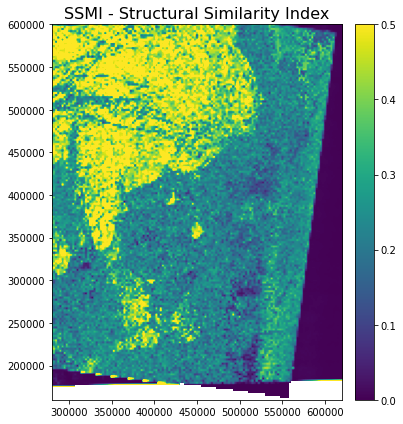

In [48]:
# plot retrieved matrices
fig, ax = plt.subplots(1,1, figsize=(18,6))

# Set title and labels
ax.set_title('SSMI - Structural Similarity Index', fontsize=16)
#ax.set_xlabel('Longitude (in projection units)', fontsize=14)
#ax.set_ylabel('Latitude (in projection units)', fontsize=14)

# Display the data with a colormap that provides better contrast and understanding
im = ax.imshow(best_ssim, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 0.5, cmap='viridis')

# Add a colorbar with a label
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.01)
#cbar.set_label('SSIM Value', fontsize=14)


# Set fewer x and y ticks
ax.tick_params(axis='both')#, labelsize=12)
ax.set_xlim([0.28e6, 0.62e6]) 
ax.set_ylim([0.16e6, 0.6e6])


plt.tight_layout()

# Save plot
#plt.savefig("/home/jovyan/experiment_data/2022-2023_48h_experiment/figures/ssim_alg_sar2.png", dpi=300, bbox_inches='tight')


plt.show()


In [203]:
# Convert the proj4 string to a Nansat spatial reference object
srs = NSR(proj4)

model_d = Domain(srs, f'-te {min(X_subset.data)} {min(Y_subset.data)} {max(X_subset.data)} {max(Y_subset.data)} -tr 100 100')

n1.reproject(model_d) 
n1b1 = n1[1]
n1.undo()

n2.reproject(model_d) 
n2b1 = n2[1]
n2.undo()

#### extra

In [77]:
formatted_timestamp = HH_pairs[1][0].timestamp.strftime('%Y-%m-%dT%H:%M:%S')
print(HH_pairs[1][0].timestamp, formatted_timestamp)
#%store  formatted_timestamp

2023-02-12 08:01:51 2023-02-12T08:01:51


In [ ]:
t_sar1 = '2023-02-12T08:01:51'